# Exploration of 2023 Annotations


* Data annotated by Simon Geikie July/August 2023
* Data sourced for Ordnance Survey July/August 2023

| **Key**                     | **Meaning**                                                             |
|-----------------------------|-------------------------------------------------------------------------|
| Present (2023)           | Present in OS data \| Present in the 2023 AP \| Present in 2014 AP      |
| Absent (2023)            | Present in OS data \| Absent in the 2023 AP \| Absent in 2014 AP        |
| Absent (Present 2014)    | Absent in OS data \| Absent in the 2023 AP \| Present in 2014 AP        |
| Obscured (shadows and vegetation)    | Obscured by trees, scrub or long grass.                                 |
| Urban                    | A mask created to simplify the detection of walls to only the open landscape |
| Absent (Present 1950)    | Absent in OS data \| Present only on 1950's basemap                     |

In [1]:
# load libraries 
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString, Point, GeometryCollection
from shapely.ops import unary_union
import fiona
#import h3
#import h3pandas

In [2]:
# load data
walls = gpd.read_file("../content/labels/Walls.shp")

/Users/t.vanderplas/anaconda3/envs/pecl/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

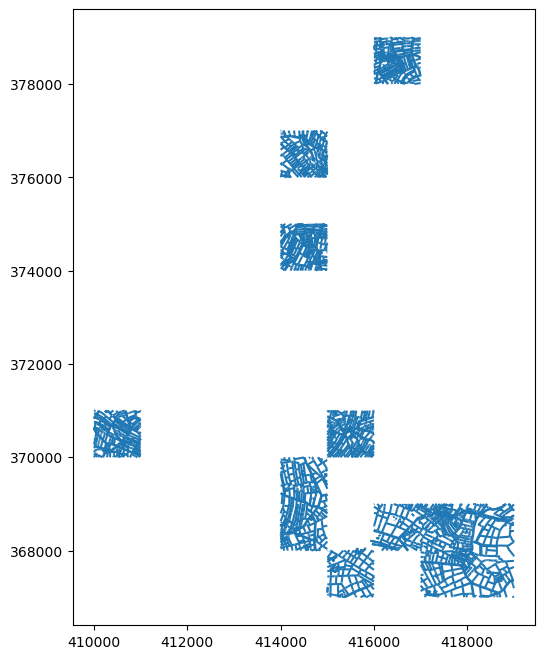

In [3]:
# take a look
walls.plot(figsize=(8,8))

In [4]:
walls.head(1)

,osid,toid,Label_2023,theme,istidal,changetype,ishistoric,isobscured,descriptio,versiondat,...,capturespe,geometry_e,descript_2,versionava,firstdigit,descript_3,versiona_1,FID_1,Shape_Leng,geometry
0,d4e434d7-ab01-49d6-af83-d747e155abae,osgb5000005154743092,Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-04-17,2014-07-24,2022-08-27T00:00:00Z,0.0,0.666023,"LINESTRING (415354.513 367005.429, 415354.887 ..."


In [5]:
walls['Label_2023'].unique()

array(['Urban', 'Present (2023)', 'Obscured (shadows and vegetation)',
       'Absent (2023)', 'Absent (Present 2014)', 'Absent (Present 1950)'],
      dtype=object)

In [6]:
walls['length'] = walls.length

In [7]:
wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)
wall_t = wall_t.T.reset_index()
wall_t

/var/folders/vg/lgb0bh9x2yx0ny2lk_h8_ylc0000gr/T/ipykernel_57762/3379901016.py:1: FutureWarning: The provided callable <function sum at 0x115dc5d80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)


,Label_2023,length
0,Absent (2023),1775.155251
1,Absent (Present 1950),33302.576547
2,Absent (Present 2014),1950.483098
3,Obscured (shadows and vegetation),40182.210978
4,Present (2023),202160.536977
5,Urban,44043.508570


In [8]:
data = ['Absent', 'Absent', 'Absent', 'Present', 'Present', 'Urban' ]
wall_t['presence'] = data
wall_t

,Label_2023,length,presence
0,Absent (2023),1775.155251,Absent
1,Absent (Present 1950),33302.576547,Absent
2,Absent (Present 2014),1950.483098,Absent
3,Obscured (shadows and vegetation),40182.210978,Present
4,Present (2023),202160.536977,Present
5,Urban,44043.508570,Urban


In [9]:
# for graph only
wall_t = wall_t.drop(index=(5))
pivot = pd.pivot_table(data=wall_t, index=['presence'], columns=['Label_2023'], values='length')

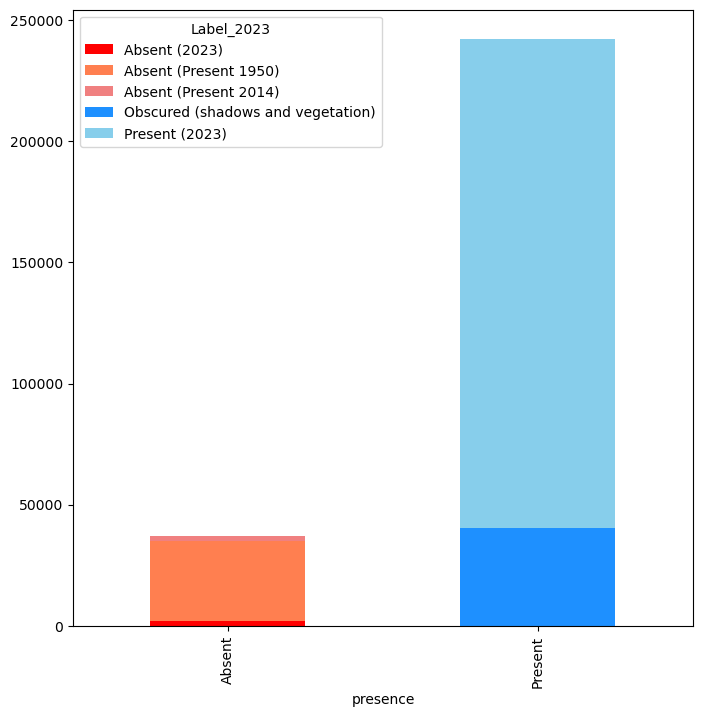

In [10]:
color = ['red', 'coral', 'lightcoral', 'dodgerblue', 'skyblue']
ax = pivot.plot.bar(stacked=True, figsize=(8,8), color=color)

# Exploration of Predictions

In [ ]:
# Load the original and clipping shapefiles
os = gpd.read_file("../QGIS/PDNP_fieldboundary/os-intersect-clip.shp") # from intersection in GIS
# clip the data buffer and save
os = os.buffer(10)
# Use unary_union to dissolve all features into one geometry
os = unary_union(os)
# Create a new GeoDataFrame with the dissolved geometry
os = gpd.GeoDataFrame(geometry=[os], crs="EPSG:27700")
# save to file
os.to_file("../content/1950-corridors/2024-corridors.shp")


In [11]:
#mask = gpd.read_file('../QGIS/masks/combined-mask.shp')
oldcorridors = gpd.read_file("../content/1950-corridors/1950-corridors.shp")
newcorridors = gpd.read_file("../content/1950-corridors/2024-corridors.shp")


/Users/t.vanderplas/anaconda3/envs/pecl/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/t.vanderplas/anaconda3/envs/pecl/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


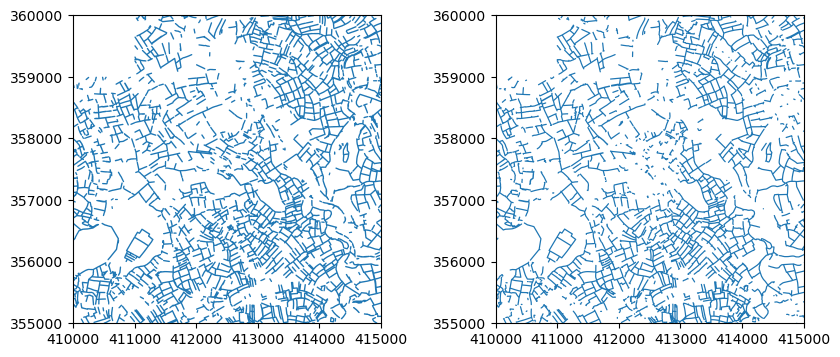

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
oldcorridors.plot(ax=ax[0])
newcorridors.plot(ax=ax[1])
for ax_ in ax:
    ax_.set_xlim([410000, 415000])
    ax_.set_ylim([355000, 360000])

In [12]:
def calculate_estimated_length(buffered_gdf, buffer_width_each_side):
    # Calculate the total perimeter of the buffered polygons
    total_perimeter = buffered_gdf.geometry.length.sum()
    
    # Estimate the total length of the original linear features
    # Assuming the buffer was applied equally on both sides
    estimated_total_length = (total_perimeter / 2) - (buffer_width_each_side * 2 * len(buffered_gdf))
    
    return estimated_total_length

def print_estimated_lengths_and_differences(oldcorridors, newcorridors, buffer_width_each_side):
    old_estimated_length = calculate_estimated_length(oldcorridors, buffer_width_each_side)
    new_estimated_length = calculate_estimated_length(newcorridors, buffer_width_each_side)
    
    # Convert meters to kilometers
    old_estimated_length_km = old_estimated_length / 1000
    new_estimated_length_km = new_estimated_length / 1000
    
    # Calculate differences and percentage change
    difference = old_estimated_length - new_estimated_length
    difference_km = difference / 1000
    percent_change = (difference / old_estimated_length) * 100 if old_estimated_length else 0
    
    # Print results
    print(f"Estimated total length of original linear features in old corridors: {old_estimated_length} meters ({old_estimated_length_km:.2f} km)")
    print(f"Estimated total length of original linear features in new corridors: {new_estimated_length} meters ({new_estimated_length_km:.2f} km)")
    print(f"Difference (old - new): {difference} meters ({difference_km:.2f} km)")
    print(f"Percentage change: {percent_change:.2f}%")

# Assuming buffer_width_each_side is 10 meters on each side of the original line
buffer_width_each_side = 10

# Print estimated lengths and differences
print_estimated_lengths_and_differences(oldcorridors, newcorridors, buffer_width_each_side)


Estimated total length of original linear features in old corridors: 4676070.345916703 meters (4676.07 km)
Estimated total length of original linear features in new corridors: 4139408.9972315696 meters (4139.41 km)
Difference (old - new): 536661.3486851337 meters (536.66 km)
Percentage change: 11.48%


#### Lets MAP

In [5]:
# Function to calculate the estimated length for each grid cell
def calculate_estimated_length_within_grid(grid_cell, corridors_gdf, buffer_width_each_side):
    # Clip the corridors to the boundary of the grid cell
    clipped_lines = gpd.clip(corridors_gdf, grid_cell.geometry)
    
    # Calculate the total length of the clipped lines within the grid cell
    total_perimeter = clipped_lines.length.sum()
    
    # Calculate the estimated original length, adjusting for the buffer width
    estimated_total_length = (total_perimeter / 2) - (buffer_width_each_side * 2 * len(clipped_lines))
    
    return estimated_total_length

# Function to calculate and append lengths to the grid
def append_lengths_to_grid(osgrid, oldcorridors, newcorridors, buffer_width_each_side):
    osgrid['old_len'] = osgrid.apply(lambda row: calculate_estimated_length_within_grid(row, oldcorridors, buffer_width_each_side), axis=1)
    osgrid['new_len'] = osgrid.apply(lambda row: calculate_estimated_length_within_grid(row, newcorridors, buffer_width_each_side), axis=1)

# Assuming buffer_width_each_side is 10 meters on each side of the original line
buffer_width_each_side = 10

# Load the grid and the corridors GeoDataFrames
osgrid = gpd.read_file("../content/landscape_character_grid/selection_white_peak.shp")
oldcorridors = gpd.read_file("../content/1950-corridors/1950-corridors.shp")
newcorridors = gpd.read_file("../content/1950-corridors/2024-corridors.shp")

# Append the lengths to the grid
append_lengths_to_grid(osgrid, oldcorridors, newcorridors, buffer_width_each_side)

# Now `osgrid` contains `old_len` and `new_len` columns with the calculated lengths
# You can save this updated grid to a new file or use it for further analysis/visualization
osgrid.to_file("../content/1950-corridors/osgrid_with_lengths.shp")


In [6]:
# check its worked
df = gpd.read_file("../content/1950-corridors/osgrid_with_lengths.shp")
# df = gpd.read_file(("../content/1950-corridors/osgrid_with_lengths.shp"))
# Add 'diff_len' column as the difference between 'new_len' and 'old_len'
df['diff_len'] = df['new_len'] - df['old_len']

# Add 'perc_diff' column showing the percentage difference for each grid square
df['perc_diff'] = ((df['new_len'] - df['old_len']) / df['old_len'] * 100).fillna(0)

# Convert lengths from meters to kilometers for individual grid squares
df['old_len_km'] = df['old_len'] / 1000
df['new_len_km'] = df['new_len'] / 1000
df['diff_len_km'] = df['diff_len'] / 1000

# Calculate the sum of 'old_len', 'new_len', and 'diff_len' in kilometers for overall statistics
total_old_len_km = df['old_len_km'].sum()
total_new_len_km = df['new_len_km'].sum()
total_diff_len_km = df['diff_len_km'].sum()

# Calculate average percentage change
average_perc_diff = df['perc_diff'].mean()

# Print the results in kilometers and percentage
print(f"Total Old Length: {total_old_len_km:.2f} km")
print(f"Total New Length: {total_new_len_km:.2f} km")
print(f"Total Length Difference: {total_diff_len_km:.2f} km")
print(f"Average Percentage Difference: {average_perc_diff:.2f}%")

#Optional: Save the modified GeoDataFrame with new columns
df.to_file("../content/1950-corridors/osgrid_with_lengths.shp")

Total Old Length: 4814.30 km
Total New Length: 4263.63 km
Total Length Difference: -550.67 km
Average Percentage Difference: -11.78%


C:\Users\alexad\AppData\Local\Temp\ipykernel_27680\2666142944.py:30: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file("../content/1950-corridors/osgrid_with_lengths.shp")


In [3]:
from matplotlib.colors import LinearSegmentedColormap

cmap_diff = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#13.4:C7020C-27.6:91180C-50:222222-72.8:395928-86.4:056C1A
    (0.000, (0.780, 0.008, 0.047)),
    (0.134, (0.780, 0.008, 0.047)),
    (0.276, (0.569, 0.094, 0.047)),
    (0.500, (0.133, 0.133, 0.133)),
    (0.728, (0.224, 0.349, 0.157)),
    (0.864, (0.020, 0.424, 0.102)),
    (1.000, (0.020, 0.424, 0.102))))

/tmp/ipykernel_4749/1539023812.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust the layout to fit everything


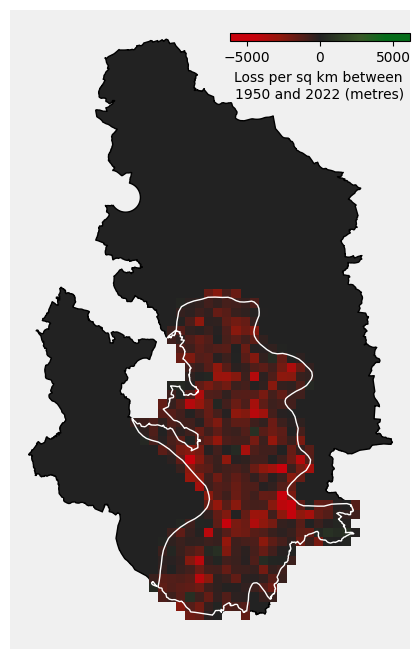

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

df = gpd.read_file("../content/1950-corridors/osgrid_with_lengths.shp")
PLOT_PDNP_OUTLINE = True
PLOT_WP_OUTLINE = True

fig = plt.figure(figsize=(4, 8))
gs_map = fig.add_gridspec(1, 1, top=1, bottom=0, left=0, right=1)
ax_map = fig.add_subplot(gs_map[0])
gs_cbar = fig.add_gridspec(1, 1, top=0.87, bottom=0.86, 
                           left=0.55 if PLOT_PDNP_OUTLINE else 0.6, 
                           right=1)
cax = fig.add_subplot(gs_cbar[0])

# Plot the DataFrame
max_abs_val = np.max(np.abs(df['diff_len']))
df.plot(column='diff_len', ax=ax_map, cmap=cmap_diff, 
        vmin=-1 * max_abs_val, vmax=max_abs_val)  # Choose a colormap

# Generate colorbar
plt.colorbar(ax_map.collections[0], cax=cax, orientation='horizontal')
cax.set_xlabel("Loss per sq km between \n1950 and 2022 (metres)")

#PDNP outline 
path_pd_outline = "../content/pdnp_boundary/National_Parks_(England)___Natural_England.shp"
path_nca_outline = '../content/nca_areas/National_Character_Areas___Natural_England.shp'
gdf_pd_outline = gpd.read_file(path_pd_outline)
gdf_pd_outline = gdf_pd_outline[gdf_pd_outline['NAME'] =='PEAK DISTRICT']
if PLOT_PDNP_OUTLINE:
    gdf_pd_outline.plot(ax=ax_map, facecolor='#222222', edgecolor='black', alpha=1, zorder=-1)

gdf_nca_outlines = gpd.read_file(path_nca_outline)
gdf_wp_outline = gdf_nca_outlines[gdf_nca_outlines['NCA_Name'] == 'White Peak']
gdf_wp_outline = gpd.clip(gdf_wp_outline, gdf_pd_outline)
if PLOT_WP_OUTLINE:
    gdf_wp_outline.plot(ax=ax_map, facecolor='none', edgecolor='white')

## add gray background
ax_map.set_facecolor('#f0f0f0')


## hide axes and ticks
for sp in ['top', 'bottom', 'right', 'left']:
    ax_map.spines[sp].set_visible(False)
ax_map.set_xticks([])
ax_map.set_yticks([])

plt.tight_layout()  # Adjust the layout to fit everything
plt.show()

/tmp/ipykernel_4749/3768266692.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust the layout to fit everything


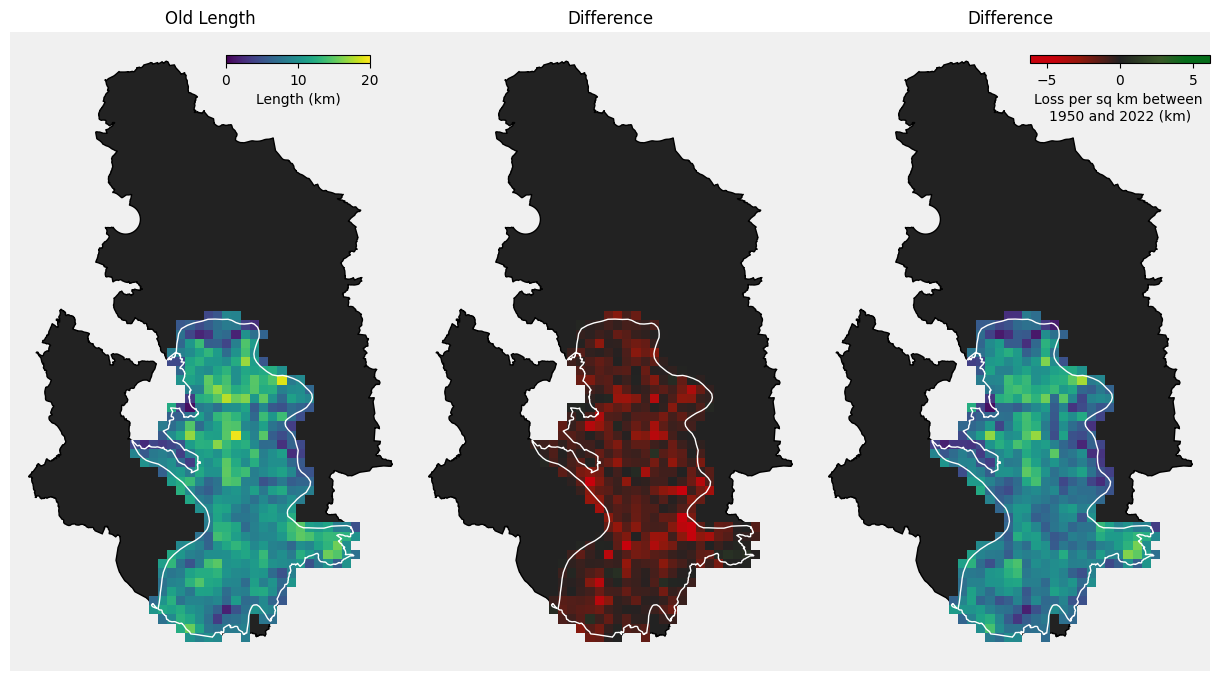

In [11]:
df = gpd.read_file("../content/1950-corridors/osgrid_with_lengths.shp")
# df['diff_len_k'] = df['diff_len'] / 1000
path_pd_outline = "../content/pdnp_boundary/National_Parks_(England)___Natural_England.shp"
path_nca_outline = '../content/nca_areas/National_Character_Areas___Natural_England.shp'
gdf_pd_outline = gpd.read_file(path_pd_outline)
gdf_pd_outline = gdf_pd_outline[gdf_pd_outline['NAME'] =='PEAK DISTRICT']
gdf_nca_outlines = gpd.read_file(path_nca_outline)
gdf_wp_outline = gdf_nca_outlines[gdf_nca_outlines['NCA_Name'] == 'White Peak']
gdf_wp_outline = gpd.clip(gdf_wp_outline, gdf_pd_outline)

PLOT_PDNP_OUTLINE = True
PLOT_WP_OUTLINE = True

fig = plt.figure(figsize=(12, 8))
gs_map = fig.add_gridspec(1, 3, top=1, bottom=0, left=0, right=1, wspace=0, hspace=0)
ax_map_list = [fig.add_subplot(gs_map[ii]) for ii in range(3)]
gs_cbar_diff = fig.add_gridspec(1, 1, top=0.87, bottom=0.86, 
                           left=0.85 if PLOT_PDNP_OUTLINE else 0.8, 
                           right=1)
cax = fig.add_subplot(gs_cbar_diff[0])
gs_cbar_len = fig.add_gridspec(1, 1, top=0.87, bottom=0.86, 
                           left=0.18,  right=0.3)
cax_len = fig.add_subplot(gs_cbar_len[0])

## Old Length
df.plot(column='old_len_km', ax=ax_map_list[0], cmap='viridis', vmin=0, vmax=20)  # Choose a colormap
plt.colorbar(ax_map_list[0].collections[0], cax=cax_len, orientation='horizontal')
cax_len.set_xlabel("Length (km)")
## New Length
df.plot(column='new_len_km', ax=ax_map_list[2], cmap='viridis', vmin=0, vmax=20)  # Choose a colormap

# Difference
max_abs_val = np.max(np.abs(df['diff_len_k']))
df.plot(column='diff_len_k', ax=ax_map_list[1], cmap=cmap_diff, 
        vmin=-1 * max_abs_val, vmax=max_abs_val)  # Choose a colormap

plt.colorbar(ax_map_list[1].collections[0], cax=cax, orientation='horizontal')
cax.set_xlabel("Loss per sq km between \n1950 and 2022 (km)")

for ax_map in ax_map_list:
    #PDNP outline 
    if PLOT_PDNP_OUTLINE:
        gdf_pd_outline.plot(ax=ax_map, facecolor='#222222', edgecolor='black', alpha=1, zorder=-1)

    if PLOT_WP_OUTLINE:
        gdf_wp_outline.plot(ax=ax_map, facecolor='none', edgecolor='white')

    ## add gray background
    ax_map.set_facecolor('#f0f0f0')

    ## hide axes and ticks
    for sp in ['top', 'bottom', 'right', 'left']:
        ax_map.spines[sp].set_visible(False)
    ax_map.set_xticks([])
    ax_map.set_yticks([])

ax_map_list[0].set_title("Old Length")
ax_map_list[1].set_title("Difference")
ax_map_list[2].set_title("Difference")

plt.tight_layout()  # Adjust the layout to fit everything
plt.show()

In [54]:
df.columns
# for c in ['old_len', 'new_len', 'diff_len']:
#     print(c, f'min {df[c].min()}, max {df[c].max()}')

Index(['PLAN_NO', 'MAPNUM', 'SQNUM', 'B1_70', 'B2_70', 'B3_70', 'B6_70',
       'B1_80', 'B2_80', 'B3_80', 'B6_80', 'A1_70', 'A2_70', 'A3_70', 'A4_70',
       'A5_70', 'A6_70', 'A7_70', 'A8_70', 'A1_80', 'A2_80', 'A3_80', 'A4_80',
       'A5_80', 'A6_80', 'A7_80', 'A8_80', 'A9_70', 'A9_80', 'TYNO', 'INPARK',
       'COUNTY', 'DISTRICT', 'PARISH', 'TYSQ10', 'EASTM', 'NORTHM', 'ONE',
       'MI_PRINX', 'index_righ', 'JCACODE', 'JCANAME', 'NCA_Name', 'NAID',
       'NANAME', 'Area_SqKM', 'Hotlink', 'ALT', 'BLT', 'old_len', 'new_len',
       'diff_len', 'perc_diff', 'old_len_km', 'new_len_km', 'diff_len_k',
       'geometry'],
      dtype='object')

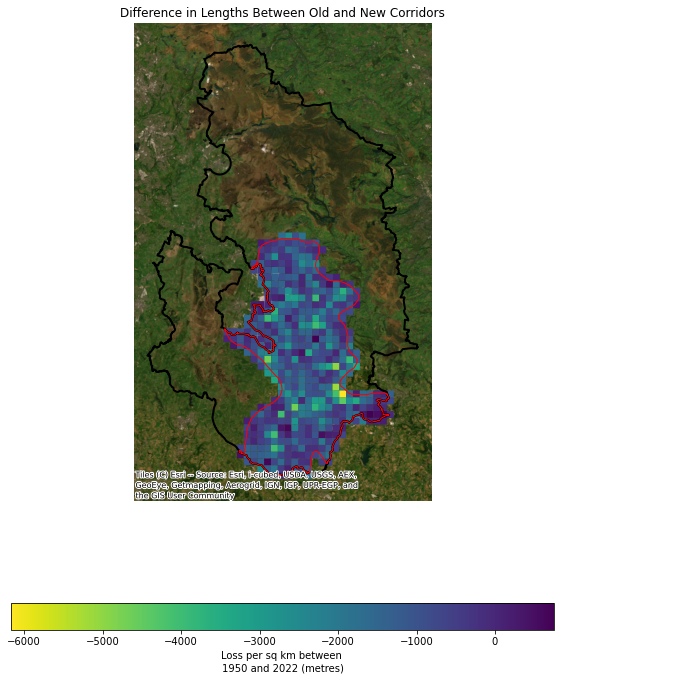

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

def transform_crs(*gdfs, epsg=3857):
    """Transform the CRS of multiple GeoDataFrames to the specified EPSG code."""
    return [gdf.to_crs(epsg=epsg) for gdf in gdfs]

# Read and prepare data
df = gpd.read_file("../content/1950-corridors/osgrid_with_lengths.shp")
path_pd_outline = "../content/pdnp_boundary/National_Parks_(England)___Natural_England.shp"
path_nca_outline = '../content/nca_areas/National_Character_Areas___Natural_England.shp'
gdf_pd_outline = gpd.read_file(path_pd_outline)
gdf_nca_outlines = gpd.read_file(path_nca_outline)

# Filter outlines
gdf_pd_outline = gdf_pd_outline[gdf_pd_outline['NAME'] == 'PEAK DISTRICT']
gdf_wp_outline = gdf_nca_outlines[gdf_nca_outlines['NCA_Name'] == 'White Peak']
gdf_wp_outline = gpd.clip(gdf_wp_outline, gdf_pd_outline)

# Transform CRS
df, gdf_pd_outline, gdf_wp_outline = transform_crs(df, gdf_pd_outline, gdf_wp_outline, epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
df.plot(column='diff_len', ax=ax, cmap='viridis_r', legend=True,
        legend_kwds={'label': "Loss per sq km between \n1950 and 2022 (metres)",
                     'orientation': "horizontal"})

# Add outlines
gdf_pd_outline.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
gdf_wp_outline.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)


# Generate colorbar
plt.colorbar(ax_map.collections[0], cax=cax, orientation='vertical')
cax.set_xlabel("Loss per sq km between \n1950 and 2022 (metres)")

# Adjust map appearance
ax.set_title('Difference in Lengths Between Old and New Corridors')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [101]:
ax.get_xlim()

(390904.55978705495, 434432.8592691939)

/Users/t.vanderplas/anaconda3/envs/pecl/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

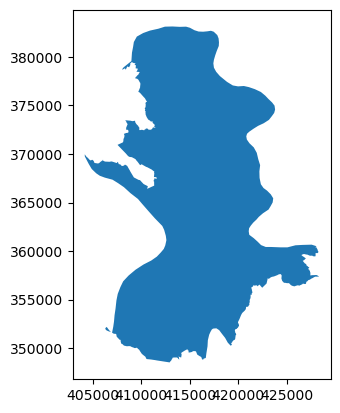

In [90]:
gpd.clip(gdf_wp_outline, gdf_pd_outline).plot()

In [2]:
import networkx as nx
import momepy

# Load 
grid_gdf = gpd.read_file("../content/1950-corridors/osgrid_with_lengths.shp")
osNGD = gpd.read_file("../QGIS/PDNP_fieldboundary/os-NGD-WP.shp")

# Sort by 'diff_len' 
highest_change_square = grid_gdf.sort_values('diff_len', ascending=False).iloc[0]
lowest_change_square = grid_gdf.sort_values('diff_len', ascending=True).iloc[0]

# Extract and clip 
highest_change_gdf = grid_gdf.loc[[highest_change_square.name]]
lowest_change_gdf = grid_gdf.loc[[lowest_change_square.name]]


clipped_osNGD_high = gpd.clip(osNGD, highest_change_gdf)
clipped_osNGD_low = gpd.clip(osNGD, lowest_change_gdf)

# Convert to networkx graphs
G_high = momepy.gdf_to_nx(clipped_osNGD_high)
G_low = momepy.gdf_to_nx(clipped_osNGD_low)

# Calculate connectivity Not really sure this is great for walls ;)
for G, label in [(G_high, 'High Change'), (G_low, 'Low Change')]:
    nodes, edges = len(G), G.size()
    beta_index = edges / nodes if nodes > 0 else 0
    gamma_index = 2 * edges / (nodes * (nodes - 1)) if nodes > 1 else 0
    
    # Print 
    print(f"{label} Area")
    print(f" - Beta Index: {beta_index}")
    print(f" - Gamma Index: {gamma_index}")
    print(f" - Nodes: {nodes}, Edges: {edges}")
    print()

High Change Area
 - Beta Index: 1.0128676470588236
 - Gamma Index: 0.0018636019265111747
 - Nodes: 1088, Edges: 1102

Low Change Area
 - Beta Index: 1.0057720057720059
 - Gamma Index: 0.0029068555080115775
 - Nodes: 693, Edges: 697



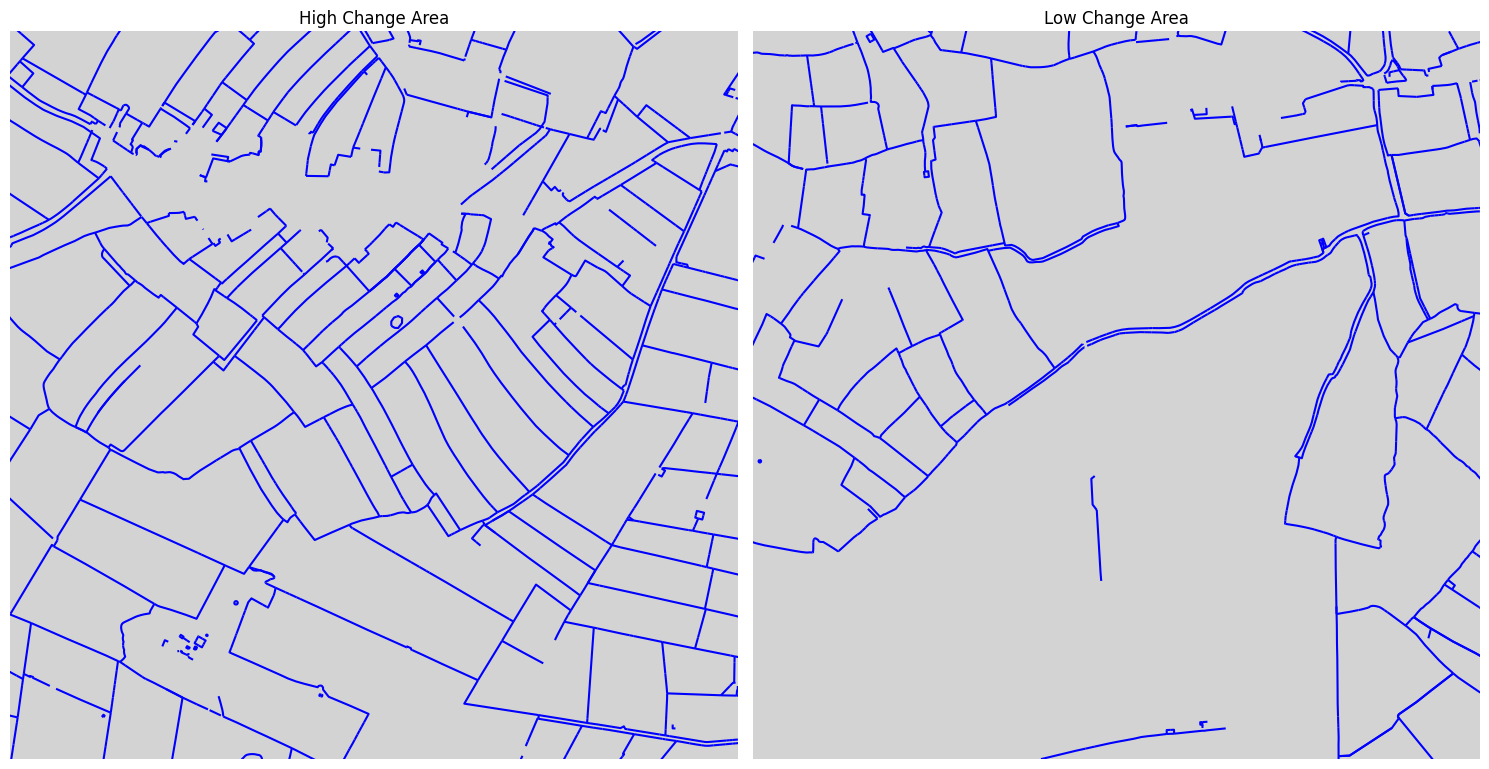

In [7]:
# Low Change Area suggests despite having fewer nodes and edges, 
# the network is more densely interconnected compared to the "High Change Area" (I think).
# Maybe change not the best thing as density seems to be key

# Plot settings
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot high change area
ax_high = axs[0]
high_square = highest_change_gdf
high_square.plot(ax=ax_high, color='lightgrey')
# Now plot the details of the features within the high change area
osNGD[osNGD.intersects(high_square.geometry.unary_union)].plot(ax=ax_high, color='blue')

# Adjust xlim and ylim for the high change area plot
ax_high.set_xlim(high_square.total_bounds[[0, 2]])
ax_high.set_ylim(high_square.total_bounds[[1, 3]])
ax_high.set_title('High Change Area')

# Plot low change area
ax_low = axs[1]
low_square = lowest_change_gdf
low_square.plot(ax=ax_low, color='lightgrey')
# Now plot the details of the features within the low change area
osNGD[osNGD.intersects(low_square.geometry.unary_union)].plot(ax=ax_low, color='blue')

# Adjust xlim and ylim for the low change area plot
ax_low.set_xlim(low_square.total_bounds[[0, 2]])
ax_low.set_ylim(low_square.total_bounds[[1, 3]])
ax_low.set_title('Low Change Area')

# Add additional settings (like axis off, title, etc.) as needed
for ax in [ax_high, ax_low]:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Accuracy

In [ ]:
# clip the data to the masks

# Load the masks and data 
mask_gdf = gpd.read_file("../QGIS/masks/combined-mask.shp")
historic_gdf = gpd.read_file("../content/1950-corridors/1950-corridors.shp")
annotations_gdf = gpd.read_file("../content/labels/Walls.shp")

# This subtracts the mask from the historic and annotations datasets
diff_historic = gpd.overlay(historic_gdf, mask_gdf, how='difference')
diff_annotations = gpd.overlay(annotations_gdf, mask_gdf, how='difference')

# Optionally, save the clipped datasets for further analysis
# This subtracts the mask from the historic and annotations datasets
diff_historic.to_file("../content/1950-corridors/diff_1950_corridors.shp")
diff_annotations.to_file("../content/1950-corridors/diff_annotations_2023.shp")

### Proximity to Annotations

In [ ]:
# buffer
gdf_2023_buffered = diff_annotations.buffer(13)
# calc intersection
intersection = diff_historic.intersection(gdf_2023_buffered.unary_union)
# Subtract This Intersection from buffer-1950
difference = diff_historic.geometry - intersection.unary_union
# Any Area Remaining is F+
false_positives_area = difference.area.sum()  # This gives the total area of false positives
# save diff
difference.to_file("../content/1950-corridors/difference.shp")

In [ ]:
total_area_1950 = diff_historic.area.sum()
percent_false_positives = (false_positives_area / total_area_1950) * 100
print(f"Percentage of False Positives: {percent_false_positives}%")

In [ ]:
# Ensure diff_annotations is a GeoDataFrame
if not isinstance(diff_annotations, gpd.GeoDataFrame):
    diff_annotations = gpd.GeoDataFrame(diff_annotations)

# Ensure diff_historic is a GeoDataFrame
if not isinstance(diff_historic, gpd.GeoDataFrame):
    diff_historic = gpd.GeoDataFrame(diff_historic)

In [ ]:
# True+ TP
tp_intersection = gpd.overlay(diff_annotations, diff_historic, how='intersection')
true_positives_area = tp_intersection.area.sum()
print(f"Total Area of True Positives: {true_positives_area}")

In [ ]:
# True- TN
aoi_area = aoi.area.sum() if isinstance(aoi, gpd.GeoDataFrame) else aoi.area

# Subtract the union of predictions and annotations from the AOI to approximate TN
covered_area = diff_historic.unary_union.union(diff_annotations_buffered.unary_union).area
true_negatives_area = aoi_area - covered_area
print(f"Approximate Area of True Negatives: {true_negatives_area}")

In [ ]:
tp_intersection = diff_annotations.intersection(diff_historic.unary_union)
true_positives_area = tp_intersection.area.sum()
print(f"Total Area of True Positives: {true_positives_area}")